# Synthetic data

In [115]:
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 100
rcParams["savefig.dpi"] = 150

# import maelstrom as ms
import numpy as np
import corner
import pandas as pd
import matplotlib.pyplot as plt
import exoplanet as xo
import pymc3 as pm


In [3]:
from maelstrom import Maelstrom

In [113]:
xo.__version__

'0.1.6.dev0'

In [135]:
from exoplanet.utils import eval_in_model
from exoplanet.orbits import get_true_anomaly
import pymc3 as pm
import theano.tensor as tt

class SyntheticBinary(object):
    """
    This class makes a synthetic light curve and injects a time delay signal corresponding to the input binary orbit parameters    
    """
    def __init__(self, time, freq, amplitude, 
                 period, eccen, asini, varpi, tref):
        self.time = time
        self.freq = freq
        self.amplitude = amplitude
        self.period, self.eccen, self.asini, self.varpi, self.tref = period, eccen, asini, varpi, tref
        
        self.make_lightcurve()
        self.flux = self.flux_true
        
    def make_lightcurve(self):
        self.flux_true = np.zeros(len(self.time))
        
        with pm.Model() as model:
            M = tt.zeros_like(tt.constant(self.time)) + 2.0 * np.pi * (tt.constant(self.time)) / self.period
            f = get_true_anomaly(M, self.eccen + tt.zeros_like(M))
            tau_tens = (- (1 - tt.square(self.eccen)) * tt.sin(f+self.varpi) / (1 + self.eccen*tt.cos(f))) * (self.asini / 86400.)
            self.tau = eval_in_model(tau_tens)
            
        for j, A_j in zip(self.freq, self.amplitude):
            omega = 2 * np.pi * j
            self.flux_true += A_j * np.cos(omega * (self.time - self.tau)) + A_j * np.sin(omega * (self.time - self.tau))
            
    def add_noise(self, noise=0.05):
        # Add noise
        self.flux_err = noise * np.std(self.flux_true)
        self.flux = self.flux_true + self.flux_err * np.random.randn(len(self.flux_true))
        
    @staticmethod
    def quick_star(self, star='dsct', mission='kepler'):
        """
        Don't use me. yet.
        """
        if star == 'dsct':
            pass

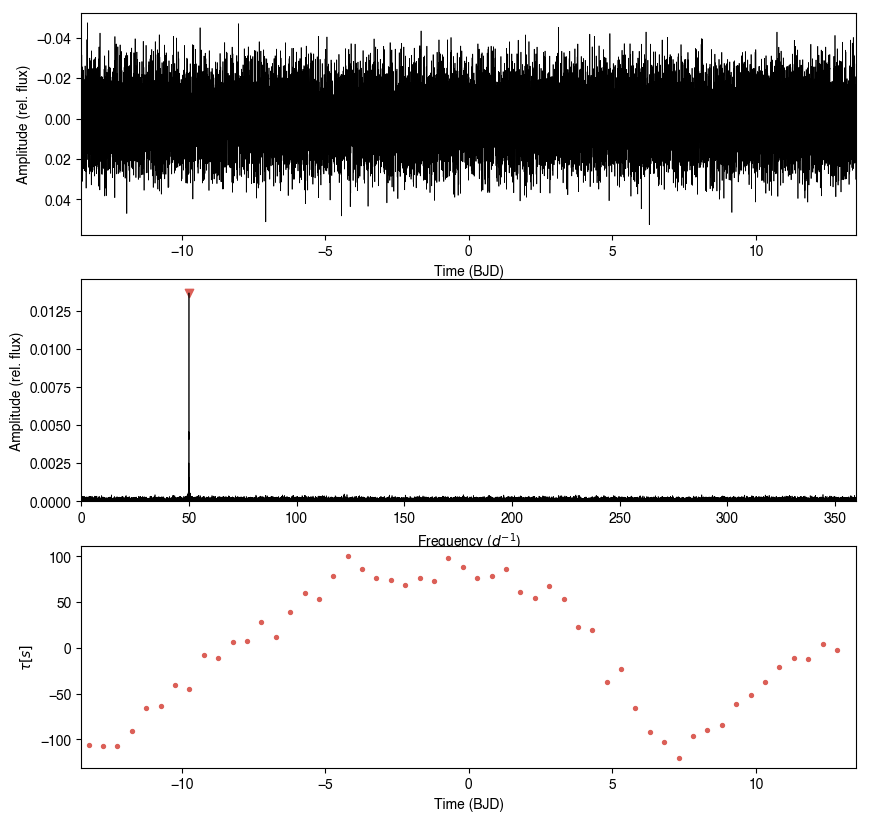

In [134]:
# Check time delay signal is injected properly
period = 20.
eccen = 0.5
asini = 100
varpi = 1.
tref = 0.

freqs = [50]
amps = [0.01]

# TESS 2 min cadence for 1 sector
time = np.arange(0, 27, 1.0 / (24 * 30))

lc = SyntheticBinary(time, freqs, amps,
                     period, eccen, asini, varpi, tref)
lc.add_noise(noise=1.)

ms = Maelstrom(lc.time, lc.flux, freq=np.array(freqs))
ms.first_look(segment_size=0.5)

Some convenience functions

In [132]:
from astropy.stats import LombScargle
from astropy.convolution import convolve, Box1DKernel
import math

def amp_spectrum(t, y, fmin=None, fmax=None, nyq_mult=1., oversample_factor=5.):
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)
    
    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = (0.5 / np.median(np.diff(t)))*nyq_mult

    freq = np.arange(fmin, fmax, df / oversample_factor)
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    fct = np.sqrt(4./len(t))
    amp = np.sqrt(sc) * fct
    
    return freq, amp


def smooth(freq, power, method='boxkernel', filter_width=0.1):

    if method == 'boxkernel':
        if filter_width <= 0.:
            raise ValueError("the `filter_width` parameter must be "
                             "larger than 0 for the 'boxkernel' method.")
        fs = np.mean(np.diff(freq))
        box_kernel = Box1DKernel(math.ceil((filter_width/fs)))
        smooth_power = convolve(power, box_kernel)
        return smooth_power

    if method == 'logmedian':
        count = np.zeros(len(freq), dtype=int)
        bkg = np.zeros_like(freq)
        x0 = np.log10(freq[0])
        while x0 < np.log10(freq[-1]):
            m = np.abs(np.log10(freq) - x0) < filter_width
            if len(bkg[m] > 0):
                bkg[m] += np.nanmedian(power)
                count[m] += 1
            x0 += 0.5 * filter_width
        bkg /= count
        smooth_power = bkg
        return smooth_power

Now, iterate over an array of light curves with different noises, calculating the SNR and log probability in each light curve. Note multiprocessing doesn't work here.. It seems that Theano can't simultaneously compile two models. If you have a good workaround I'd love to see it

In [ ]:
from tqdm import tqdm as tqdm

snr = []
logp = []
noises = np.arange(0.,10.,0.1)

period = 20.
eccen = 0.5
asini = 100
varpi = 1.
tref = 0.

freqs = [50]
amps = [0.001]
time = np.arange(0, 27, 1.0 / (24 * 30))

for noise in tqdm(noises):
    lc = SyntheticBinary(time, freqs,amps,
                         period, eccen, asini, varpi, tref)

    lc.add_noise(noise=noise)

    freq, amp = amp_spectrum(lc.time, lc.flux, fmin=45., fmax=55.)
    smoothed = smooth(freq, amp, filter_width=0.01, method='logmedian')
    val = amp / smoothed
    snr.append(np.max(val))
    
    ms = Maelstrom(lc.time, lc.flux, freq=np.array([50]))
    ms.setup_orbit_model(period=20.)
    opt = ms.optimize(verbose=False)
    logp.append(ms.logp(opt))

We plot the SNR of the frequency vs the log probability of the model after optimizing. I'm not sure why there's a big discontinuity near SNR 300, but the earlier stuff looks OK

Text(0, 0.5, 'Log probability')

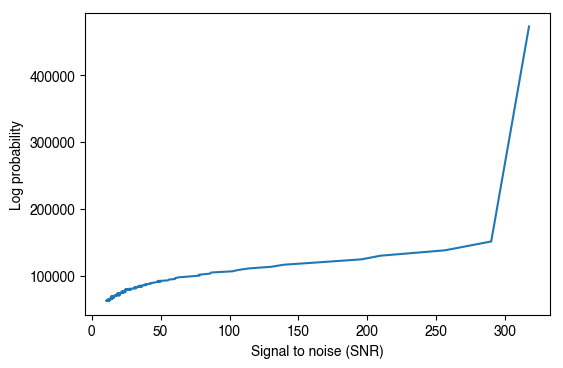

In [133]:
plt.plot(snr, logp)
plt.xlabel('Signal to noise (SNR)')
plt.ylabel('Log probability')

Other stuff; the meshgrid of period and asini.

In [74]:
period = np.arange(1,27,1)
asini = np.arange(1,100, 5)

In [34]:
from tqdm import tqdm_notebook as tqdm
time = np.arange(0, 27, 1.0 / (24 * 30))
logp = []
for p in period:
    for a in tqdm(asini):
        eccen = 0.5
        varpi = 1.
        tref = 0.

        n_freqs = 1
        freqs = [50]
        amps = [1]
        

        lc = SyntheticBinary(time, freqs,amps,
                             p, eccen, a, varpi, tref)
        
        ms = Maelstrom(lc.time, lc.flux, 
               freq=freqs,
               #max_peaks=1
              )
        ms.setup_orbit_model(period=p)
        opt = ms.optimize()
        logp.append(ms.logp(opt))

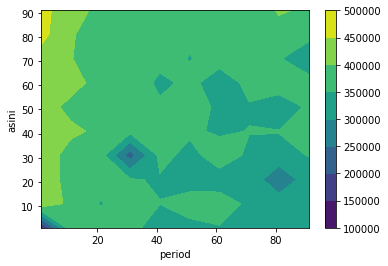

In [70]:
plt.contourf(period, asini, new_logp.reshape(len(period), len(asini)))
plt.xlabel('period')
plt.ylabel('asini')
plt.colorbar()